In [1]:
from data_pipeline.retrieval import DataBank, download_adj_close
from data_pipeline.processing import ClusterInput



from sklearn.metrics import calinski_harabasz_score
def get_CH_score(df, clusters):
    labels = [clusters[col] for col in df.columns]
    X = df.T.values # transposes data so that features are columns instead of rows
    return calinski_harabasz_score(X, labels)


In [24]:
data_bank = DataBank()
ticker_to_sector_map = data_bank.ticker_to_sector_map()

start = '2023-09-01'
end = '2023-11-27'

tickers = data_bank.get_tickers()

In [25]:
adj_closing_prices = download_adj_close(tickers, start, save_data=True)


Data for this time interval not found. Loading data...
Failed to load saved data. Loading data...
[*********************100%%**********************]  503 of 503 completed


2 Failed downloads:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2023-09-01 -> 2023-11-29)')


In [26]:
ROR = adj_closing_prices.pct_change().dropna()

sec_to_tick = data_bank.sector_to_ticker_map(tickers = ROR.columns)
tick_to_sect = data_bank.ticker_to_sector_map(tickers = ROR.columns)


In [114]:
TECH = sec_to_tick['Information Technology']
TECH = ROR[TECH][-30:]

TECH['Tech Average'] = TECH.mean(axis = 1)

KeyError: "None of [Index(['AAPL', 'ACN', 'ADBE', 'ADI', 'ADSK', 'AKAM', 'AMAT', 'AMD', 'ANET',\n       'ANSS', 'APH', 'AVGO', 'CDNS', 'CDW', 'CRM', 'CSCO', 'CTSH', 'ENPH',\n       'EPAM', 'FFIV', 'FICO', 'FSLR', 'FTNT', 'GEN', 'GLW', 'HPE', 'HPQ',\n       'IBM', 'INTC', 'INTU', 'IT', 'JNPR', 'KEYS', 'KLAC', 'LRCX', 'MCHP',\n       'MPWR', 'MSFT', 'MSI', 'MU', 'NOW', 'NTAP', 'NVDA', 'NXPI', 'ON',\n       'ORCL', 'PANW', 'PTC', 'QCOM', 'QRVO', 'ROP', 'SEDG', 'SNPS', 'STX',\n       'SWKS', 'TDY', 'TEL', 'TER', 'TRMB', 'TXN', 'TYL', 'VRSN', 'WDC',\n       'ZBRA'],\n      dtype='object')] are in the [columns]"

Text(0.5, 0, 'Date')

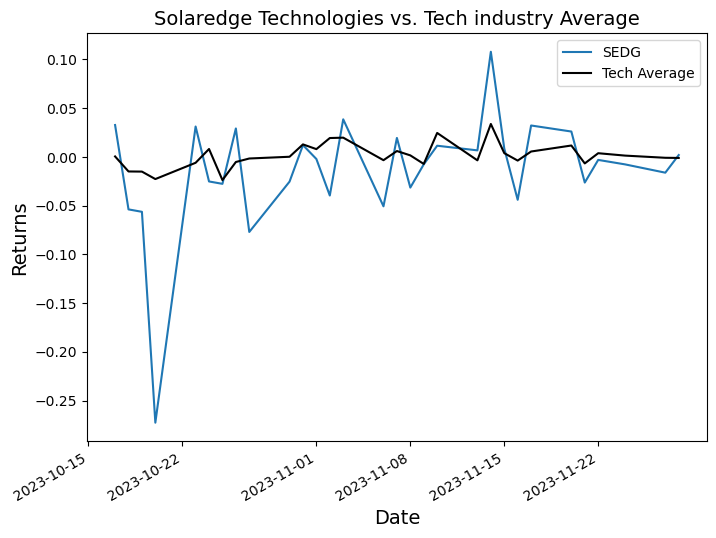

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize = (8,6))

TECH[["SEDG"]].plot(ax = ax)
TECH[["Tech Average"]].plot(ax = ax, color = 'black')
ax.set_title("Solaredge Technologies vs. Tech industry Average", fontsize = 14)
ax.set_ylabel("Returns", fontsize = 14)
ax.set_xlabel("Date", fontsize = 14)
# ANET, ENPH # FSLR SEDG VRSN



# Making images of the pipeline

In [212]:
from matplotlib.collections import LineCollection
import matplotlib.dates as mdates
import matplotlib.cm as cm

def colorplot(df, tick, ax, color = 'Percent'):
    tick_df = df[[tick]].copy()#.rolling(10).mean().dropna().copy()
    if color == 'Percent':
        tick_df['color'] = tick_df.pct_change()
    else:
        tick_df['color'] = tick_df[tick]    
    
    tick_df = tick_df.dropna()

    xs = mdates.date2num(tick_df.index.to_pydatetime())
    pts = list(zip(xs, tick_df[tick].values))
    segs = [[pts[i], pts[i+1]] for i in range(len(pts) - 1)]
    segments = np.hstack([segs[:-1], segs[1:]])
    
    colours = tick_df.color.values
    colours_normalized = (colours - min(colours))/(max(colours) - min(colours))
    cmap = cm.RdYlGn(colours_normalized)
    coll = LineCollection(segments, colors = cmap)
    
    ax.add_collection(coll)
    ax.autoscale_view()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    monthFmt = mdates.DateFormatter("%b")
    ax.xaxis.set_major_formatter(monthFmt)

In [213]:

columns = adj_closing_prices.columns
sec_to_tick = data_bank.sector_to_ticker_map(tickers = columns)

HEALTH = sec_to_tick['Health Care']

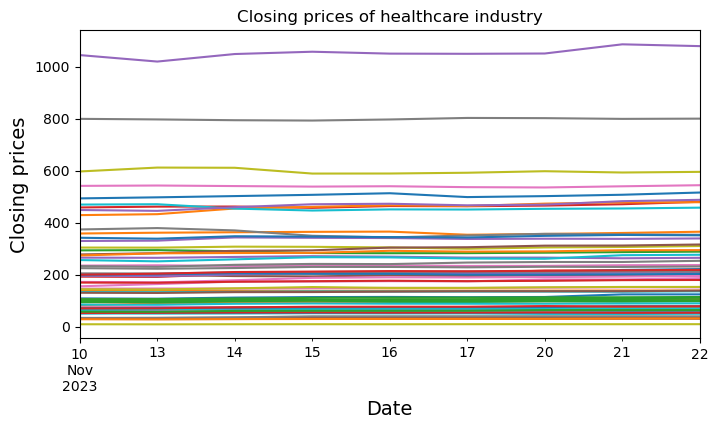

In [226]:

import numpy as np
from matplotlib.ticker import FormatStrFormatter

month_closing_prices = adj_closing_prices[HEALTH][-12:-3]

f, ax = plt.subplots(figsize = (8,4))
ax.set_title("Closing prices of healthcare industry")

month_closing_prices.plot(ax = ax, legend = False)
#for tick in HEALTH:
#    colorplot(month_closing_prices, tick, ax = ax)
    #colorplot(closing_prices_l2, tick, axarr[0])#, closing_prices_l2[[tick]].pct_change())
    #colorplot(ROR, tick, axarr[1], color = 'value')

ax.set_ylabel("Closing prices", fontsize = 14)
ax.set_xlabel("Date", fontsize = 14)
#ax.xaxis.set_minor_formatter(FormatStrFormatter("%.2f"))

plt.show()


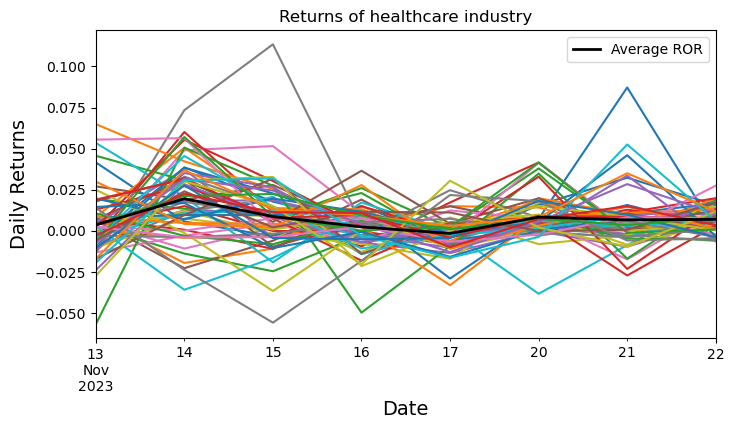

In [227]:
month_ROR = month_closing_prices.pct_change().dropna()
f, ax = plt.subplots(figsize = (8,4))
ax.set_title("Returns of healthcare industry")
month_ROR.plot(ax = ax, legend = False)
#for tick in HEALTH:
#    colorplot(month_ROR, tick, ax = ax, color = 'value')
    #colorplot(closing_prices_l2, tick, axarr[0])#, closing_prices_l2[[tick]].pct_change())
    #colorplot(ROR, tick, axarr[1], color = 'value')

average_ROR = pd.DataFrame({'Average ROR' : month_ROR.mean(axis = 1).values}, index = list(month_ROR.index))

average_ROR.plot(ax = ax, color = 'black', linewidth = 2)

ax.set_ylabel("Daily Returns", fontsize = 14)
ax.set_xlabel("Date", fontsize = 14)

plt.show()


Text(0.5, 0, 'Date')

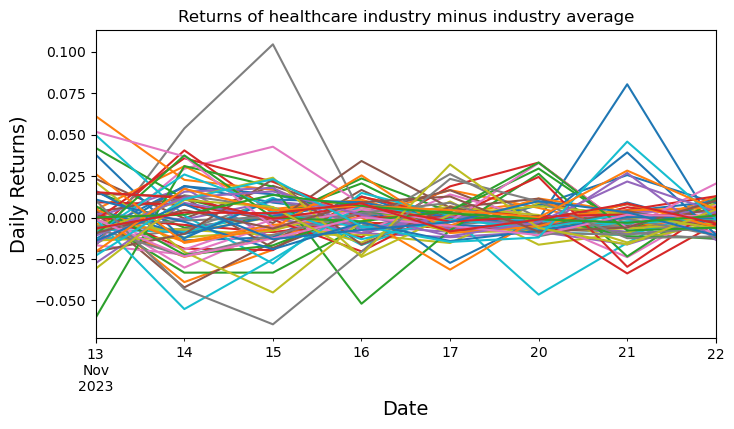

In [228]:
month_ROR_ind_adjust = month_ROR.sub(average_ROR.values, axis = 0)#.rolling(2).mean().dropna()

f, ax = plt.subplots(figsize = (8,4))
ax.set_title("Returns of healthcare industry minus industry average")
month_ROR_ind_adjust.plot(ax = ax, legend = False)
    #colorplot(closing_prices_l2, tick, axarr[0])#, closing_prices_l2[[tick]].pct_change())
    #colorplot(ROR, tick, axarr[1], color = 'value')

#average_ROR = pd.DataFrame({'Average ROR' : month_ROR.mean(axis = 1).values}, index = list(month_ROR.index))

#average_ROR.plot(ax = ax, color = 'black')

ax.set_ylabel("Daily Returns)", fontsize = 14)
ax.set_xlabel("Date", fontsize = 14)


Text(0.5, 0, 'Date')

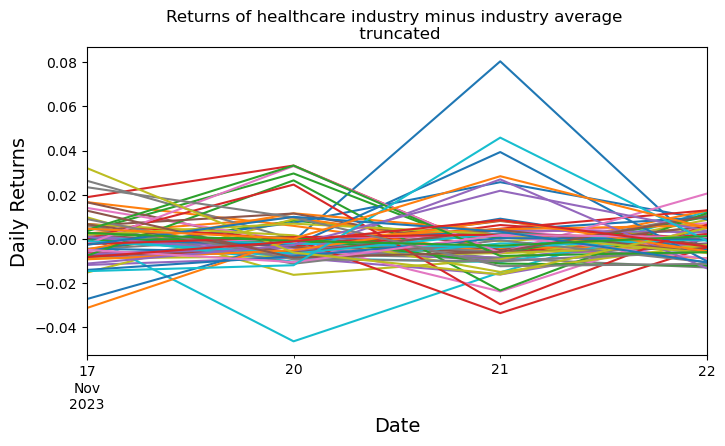

In [229]:
month_ROR_ind_adjust_trunc = month_ROR_ind_adjust[-4:]

f, ax = plt.subplots(figsize = (8,4))
ax.set_title("Returns of healthcare industry minus industry average \n truncated")
month_ROR_ind_adjust_trunc.plot(ax = ax, legend = False)
    #colorplot(closing_prices_l2, tick, axarr[0])#, closing_prices_l2[[tick]].pct_change())
    #colorplot(ROR, tick, axarr[1], color = 'value')

#average_ROR = pd.DataFrame({'Average ROR' : month_ROR.mean(axis = 1).values}, index = list(month_ROR.index))

#average_ROR.plot(ax = ax, color = 'black')

ax.set_ylabel("Daily Returns", fontsize = 14)
ax.set_xlabel("Date", fontsize = 14)

Text(0.5, 0, 'Date')

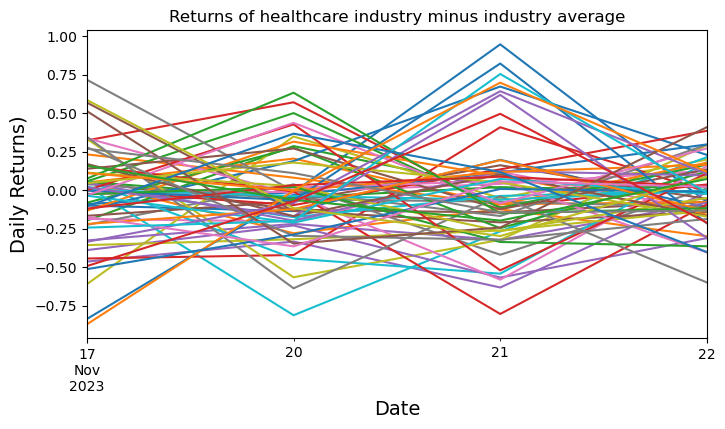

In [232]:

from data_pipeline.processing import l2_normalization

month_ROR_ind_adjust_l2 = l2_normalization(month_ROR.sub(average_ROR.values, axis = 0))[-4:]

f, ax = plt.subplots(figsize = (8,4))
ax.set_title("Returns of healthcare industry minus industry average")
month_ROR_ind_adjust_l2.plot(ax = ax, legend = False)
    #colorplot(closing_prices_l2, tick, axarr[0])#, closing_prices_l2[[tick]].pct_change())
    #colorplot(ROR, tick, axarr[1], color = 'value')

#average_ROR = pd.DataFrame({'Average ROR' : month_ROR.mean(axis = 1).values}, index = list(month_ROR.index))

#average_ROR.plot(ax = ax, color = 'black')

ax.set_ylabel("Daily Returns)", fontsize = 14)
ax.set_xlabel("Date", fontsize = 14)

In [137]:
average_ROR

,Average ROR
2023-09-06,-0.002632
2023-09-07,-0.004120
2023-09-08,-0.005846
2023-09-11,0.007163
2023-09-12,-0.005382
2023-09-13,0.002093
2023-09-14,0.004085
2023-09-15,-0.005623
2023-09-18,-0.005232
2023-09-19,0.000874


In [6]:
# Importing some things to get rid of warnings
import os
nthreads = 1
os.environ["OMP_NUM_THREADS"] = str(nthreads) 
os.environ["OPENBLAS_NUM_THREADS"] = str(nthreads) 
os.environ["MKL_NUM_THREADS"] = str(nthreads)

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [7]:
# The usual suspects

import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
from sklearn.cluster import KMeans

import SP500models as models


In [8]:
KMeans.__dict__

mappingproxy({'__module__': 'sklearn.cluster._kmeans',
              '__doc__': 'K-Means clustering.\n\n    Read more in the :ref:`User Guide <k_means>`.\n\n    Parameters\n    ----------\n\n    n_clusters : int, default=8\n        The number of clusters to form as well as the number of\n        centroids to generate.\n\n    init : {\'k-means++\', \'random\'}, callable or array-like of shape             (n_clusters, n_features), default=\'k-means++\'\n        Method for initialization:\n\n        \'k-means++\' : selects initial cluster centers for k-mean\n        clustering in a smart way to speed up convergence. See section\n        Notes in k_init for more details.\n\n        \'random\': choose `n_clusters` observations (rows) at random from data\n        for the initial centroids.\n\n        If an array is passed, it should be of shape (n_clusters, n_features)\n        and gives the initial centers.\n\n        If a callable is passed, it should take arguments X, n_clusters and a\n  

In [14]:
class KMeans_Reclustering(KMeans):
    def __init__(self):
        KMeans.__init__(n_clusters=8, init='k-means++', n_init='warn', max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd')
    # the fit function behaves almost exactly like the usual scikit learn models.
    def refine_clusters(self, input_list, old_labels, n_clusters):

        if not len(input_list) == len(old_labels):
            print("Input dataframe list should be the same length as the old cluster labels")
            return None
        if not len(old_labels) == len(n_clusters):
            print("Defaulting to 5 clusters per old cluster")
            n_clusters = [5]*len(old_labels)
        
        # perform the kmeans fitting within each cluster:
        for df, label, n in zip(input_list, old_labels, n_clusters):
            print(f"Fitting Kmeans for {label}")
            self.__init__(n_clusters = n)
            kmeans = self.fit(df)
            labels+= [[label + str(l) for l in kmeans.labels_]]

        return labels

In [50]:
columns = adj_closing_prices.columns
labels = data_bank.get_sectors_list()
sector_to_ticker_map = data_bank.sector_to_ticker_map(columns)

sector_dfs = [adj_closing_prices.iloc[:, [1*(l == sector) for l in labels]]] for sector in labels]

KeyError: "['BF.B'] not in index"

In [56]:
labels

['Industrials',
 'Health Care',
 'Information Technology',
 'Consumer Staples',
 'Utilities',
 'Financials',
 'Consumer Discretionary',
 'Materials',
 'Real Estate',
 'Communication Services',
 'Energy']

TypeError: sector_to_ticker_map() got an unexpected keyword argument 'tickers'

<AxesSubplot:xlabel='Date'>

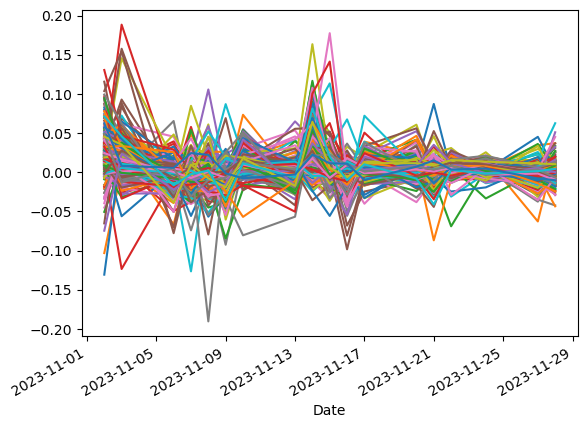

In [62]:
ROR.plot(legend = False)